In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [100]:
# numpy , pandas
import numpy as np 
import pandas as pd
# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# 可視化用ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns


In [101]:
train_df = pd.read_csv('C:/Users/user/.kaggle1/train.csv')
train_df.head()
print(train_df.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


In [102]:
#データ前処理はhousepricesと同じように行う
test_df = pd.read_csv('C:/Users/user/.kaggle1/test.csv')


In [103]:
#objectは基本的に文字情報でモデルに与えることはできない
#Label Encoder を使う
from sklearn.preprocessing import LabelEncoder
#train.shapeは(行、列)の形式よりshape[1]は列数が取得される
for i in range(train_df.shape[1]):
    if train_df.iloc[:,i].dtype == object:
        lbl = LabelEncoder()
        #ラベルとラベルIDの対応付けを行う。　これは０にするなど
        lbl.fit(list(train_df.iloc[:,i].values)+list(test_df.iloc[:,i].values))
        #それに従って変換する。返り値を保存する必要がある。
        train_df.iloc[:,i] = lbl.transform(list(train_df.iloc[:,i].values))
        test_df.iloc[:,i] = lbl.transform(list(test_df.iloc[:,i].values))



In [104]:
print(train_df['SaleCondition'].unique())

[4 0 5 1 2 3]


<Axes: >

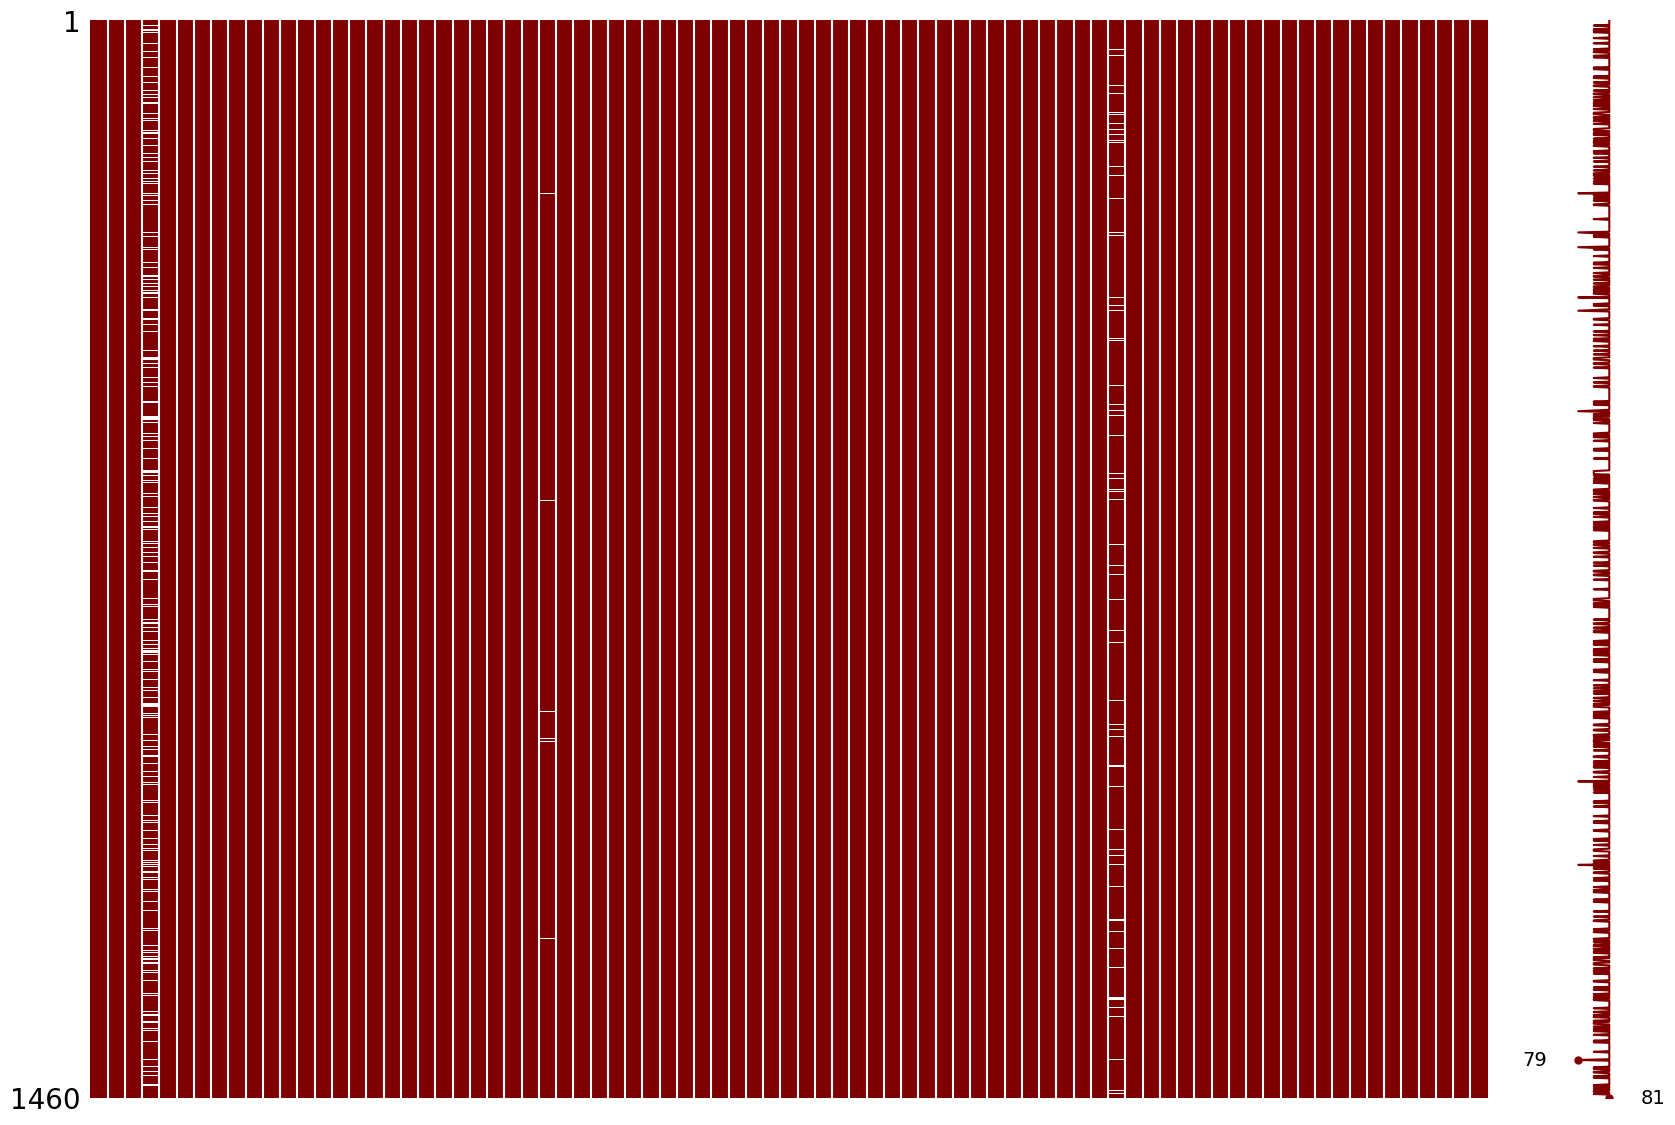

In [105]:
pd.set_option('display.max_columns', 100)
train_df.isna().sum()

# search for missing data
import missingno as msno
msno.matrix(df=train_df, figsize=(20,14), color=(0.5,0,0))



In [106]:
#欠損値対応
train_ID = train_df['Id']
test_ID = test_df['Id']

y_train = train_df['SalePrice']
X_train = train_df.drop(['Id','SalePrice'],axis=1)
X_test = test_df.drop('Id',axis=1)
#欠損値が多いものは落とす。それ以外は中央値で埋める
Xmat = pd.concat([X_train,X_test])
Xmat = Xmat.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
Xmat = Xmat.fillna(Xmat.median())



C:\Users\user\AppData\Local\Temp\ipykernel_7928\2070606393.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_train)


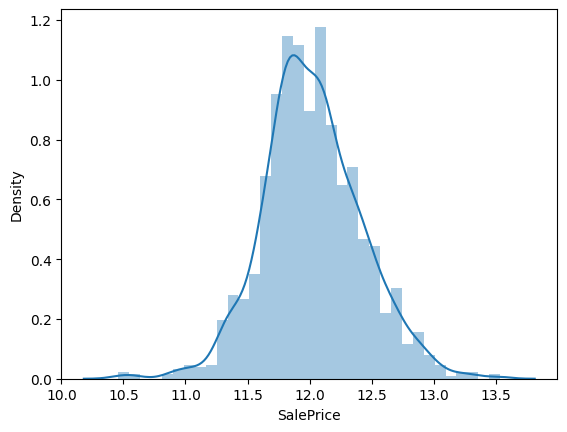

In [107]:
#新しい変数を作る
Xmat['TotalSF'] = Xmat['TotalBsmtSF']+Xmat['1stFlrSF'] + Xmat['2ndFlrSF']
#正規分布に沿うように対数化
y_train = np.log(y_train)
ax = sns.distplot(y_train)
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Training done using Random Forest


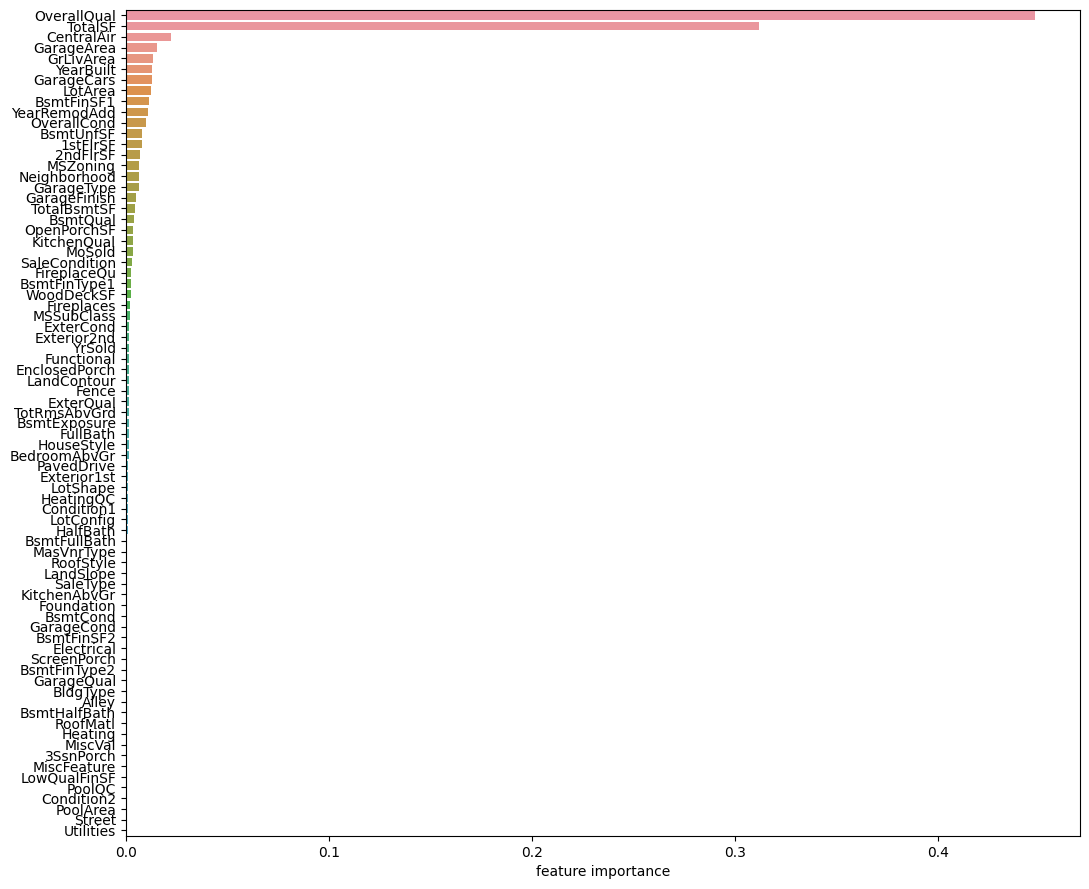

In [108]:
#どのfeatureが大切なのかチェックする
#ランダムフォレストを使う
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
#欠損値処理後のデータを利用
X_train = Xmat.iloc[X_train.index[0]:len(X_train)]
X_test = Xmat.iloc[len(X_train):]
rf.fit(X_train, y_train)
print('Training done using Random Forest')
#ランダムフォレストモデルの特徴の重要度を降順で並べる
ranking = np.argsort(-rf.feature_importances_)
#図のサイズを指定して図と軸を作成し、それぞれのオブジェクトをfとaxに割り当てる
f,ax = plt.subplots(figsize=(11,9))
sns.barplot(x=rf.feature_importances_[ranking],y=X_train.columns.values[ranking],orient='h')
#x軸のラベルを設定
ax.set_xlabel("feature importance")
#プロットが整列されるようにレイアウトを調整
plt.tight_layout()
plt.show()


In [109]:
#つまり70以上の特徴量の中でSalePriceの予測に大切なのはほんの数個しかない
#とりあえず30個の特徴を取ってきてモデルに与えて訓練する
X_train = X_train.iloc[:,ranking[:30]]
X_test = X_test.iloc[:,ranking[:30]]

#上二つの特徴を掛け合わせたものを新しい特徴量として作る

X_train['Interaction'] = X_train['TotalSF']*X_train['OverallQual']
X_test['Interaction'] = X_test['TotalSF']*X_test['OverallQual']


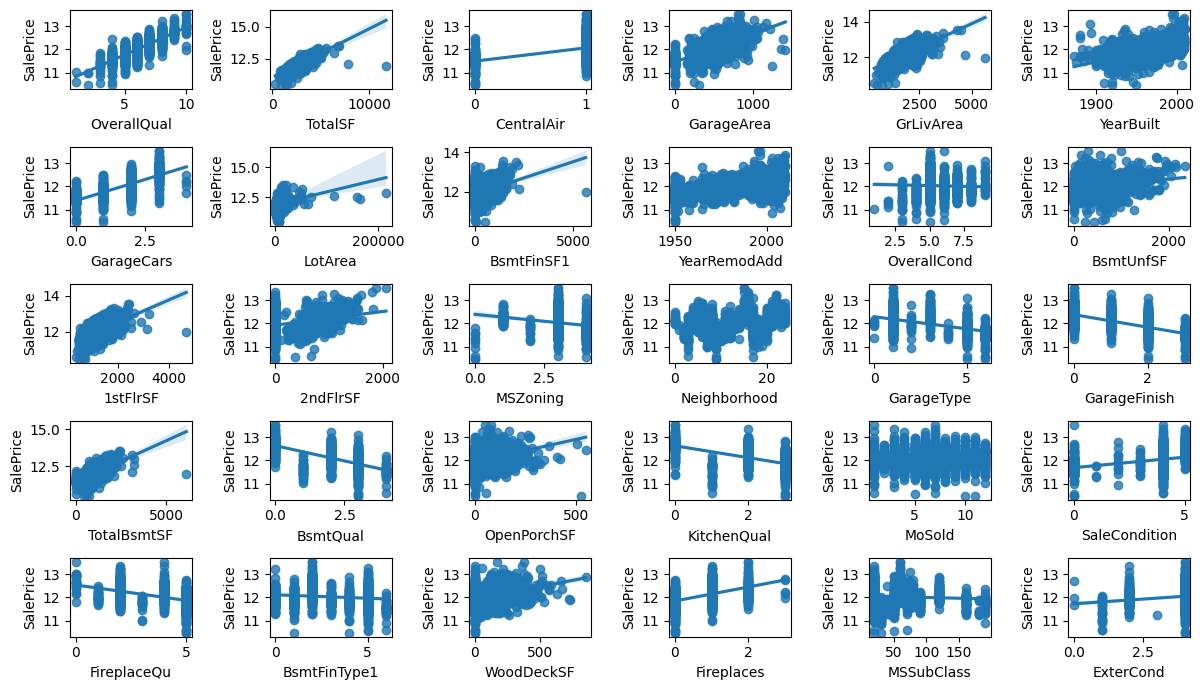

In [110]:
#各特徴とターゲットとの関係を調べる
fig = plt.figure(figsize=(12,7))
#np.arangeは連続する0~29の数値の配列を生成
#5行6列のレイアウトでi+1番目のサブプロットを指定
#各サブプロットに対して特徴量と目的変数の関係を描く
for i in np.arange(30):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=X_train.iloc[:,i],y=y_train)

plt.tight_layout()
plt.show()


In [111]:
#外れ値を除く

Xmat2 = pd.concat([X_train,y_train],axis = 1)
Xmat2 = Xmat2.drop(Xmat2[(Xmat2['TotalSF']>700)&(Xmat2['SalePrice']<12.5)].index)
Xmat2 = Xmat2.drop(Xmat2[(Xmat2['GrLivArea']>4000)&(Xmat2['SalePrice']<13)].index)

y_train = Xmat2['SalePrice']
X_train = Xmat2.drop(['SalePrice'], axis=1)


In [112]:
#モデル作成
#xgboost
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV

print('Parameter optimization')
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                    {'max_depth':[2,4,6],
                     'n_estimators':[50,100,200]},verbose=1)
reg_xgb.fit(X_train,y_train)

Parameter optimization
Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [115]:
#SVR
from sklearn.svm import SVR

reg_svr = GridSearchCV(SVR(kernel ='rbf',gamma=0.1),cv=5,
                    param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg_svr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(gamma=0.1),
             param_grid={'C': [1.0, 10.0, 100.0, 1000.0],
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [128]:

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model)
# define the grid search parameters

reg_dl = GridSearchCV(estimator=model, n_jobs=1)
reg_dl.fit(X_train, y_train)




C:\Users\user\AppData\Local\Temp\ipykernel_7928\1933219323.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model)


TypeError: GridSearchCV.__init__() missing 1 required positional argument: 'param_grid'

In [132]:
X_train2 = pd.DataFrame( {'XGB': reg_xgb.predict(X_train),
     'SVR': reg_svr.predict(X_train),
    })
X_train2.head(5)

,XGB,SVR
0,12.644131,12.734222
1,12.780853,12.736716
2,12.521905,12.640306
3,12.658299,12.736716
4,12.623178,12.731378


In [133]:
# second-feature modeling using linear regression
from sklearn import linear_model
#線形モデルを使って
reg = linear_model.LinearRegression()
reg.fit(X_train2, y_train)

X_test2 = pd.DataFrame( {'XGB': reg_xgb.predict(X_test),
     'SVR': reg_svr.predict(X_test),
    })

y_pred = np.exp(reg.predict(X_test2))

In [134]:
Id=test_ID

submission = pd.DataFrame({"Id": Id, "SalePrice": y_pred})
submission.to_csv("houseprices2.csv", index=False)